<a href="https://colab.research.google.com/github/wambak/OnlineXPMFitter/blob/main/2023mar23xpmanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
! git clone https://github.com/nEXOSkyline/XPMSimulator
! git clone https://github.com/nEXOSkyline/OnlineXPMFitter

Mounted at /content/drive
Cloning into 'XPMSimulator'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 294 (delta 35), reused 12 (delta 6), pack-reused 207
Receiving objects: 100% (294/294), 353.31 KiB | 4.71 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Cloning into 'OnlineXPMFitter'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 196 (delta 4), reused 6 (delta 2), pack-reused 187
Receiving objects: 100% (196/196), 123.45 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [5]:
! pip install numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
! pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0/content/OnlineXPMFitter/waveformCapture/captured/20230307test006
,1/content/OnlineXPMFitter/waveformCapture/captured/20230305test001
,2/content/OnlineXPMFitter/waveformCapture/captured/20230307test002
,3/content/OnlineXPMFitter/waveformCapture/captured/202303072014test000
,4/content/OnlineXPMFitter/waveformCapture/captured/20230307test005
,5/content/OnlineXPMFitter/waveformCapture/captured/20230307test001
,6/content/OnlineXPMFitter/waveformCapture/captured/202303072014test001
,7/content/OnlineXPMFitter/waveformCapture/captured/202303072014test003
,8/content/OnlineXPMFitter/waveformCapture/captured/202303070410test001
,9/content/OnlineXPMFitter/waveformCapture/captured/202303070410test000
,10/content/OnlineXPMFitter/waveformCapture/captured/20230305test000
,11/content/OnlineXPMFitter/waveformCapture/captured/202303072014test002
,12/content/OnlineXPMFitter/waveformCapture/captured/20230307test000
,13/content/OnlineXPMFitter/waveformCapture/captured/20230307test003



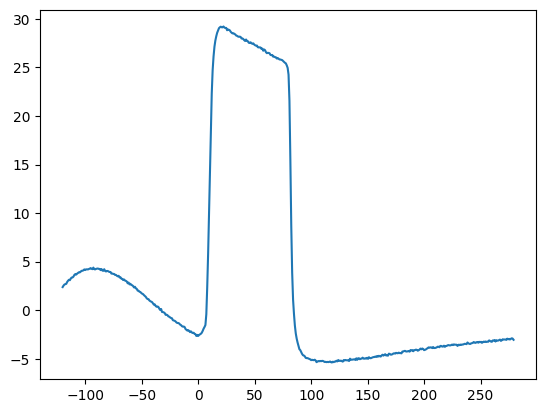

In [44]:
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
filelist = glob.glob('/content/OnlineXPMFitter/waveformCapture/captured/20*')
print((','.join([ str(num)+myfile+'\n' for num,myfile in zip( np.array(range(0,len(filelist)-1)),filelist ) ])) )
xy = np.loadtxt(filelist[6],delimiter=',')
plt.plot(xy[:,0],xy[:,1])

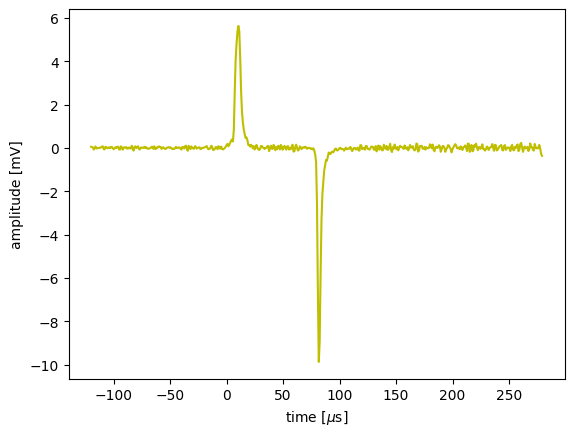

In [46]:
from uncertainties.core import wrap
import matplotlib as mpl
mpl.rc('figure',facecolor='white')
mpl.rc('lines', markersize = 1.6 )
mpl.rc('lines', markeredgewidth = 0.0 )
#mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
import matplotlib.pyplot as plt
import time
import matplotlib.dates as dt
import numpy as np
import datetime

#import ROOT
from scipy import integrate
from scipy import interpolate
from scipy.special import erfc
from scipy.optimize import curve_fit
from lmfit.models import SkewedVoigtModel
from lmfit.models import ExponentialGaussianModel
from lmfit.models import SkewedGaussianModel
from lmfit import Model
from lmfit import Parameters
import sys
sys.path.append('/content/OnlineXPMFitter/waveformCapture/captured')

pkmodel = SkewedVoigtModel()
catmodel = ExponentialGaussianModel()
pars = pkmodel.make_params()
catpars = catmodel.make_params()
err = 0.0
sqrt2 = np.sqrt(2.0)

def diff_func(x,cat,an,offst,thold,tcrise,tarise,center,gamma,skew):
    global err
    y = cat*np.exp(-((-x+10.0+tcrise**2/thold)/(sqrt2*tcrise))**2)*np.exp( -(x-10.0-tcrise**2/(2*thold))/thold )
    y = y + (-1.0/thold)*0.5*cat*np.exp( -(x-10.0-tcrise**2/(2*thold))/thold )*erfc((-x+10.0+tcrise**2/thold)/(sqrt2*tcrise))
    pars['amplitude'].value = an
    pars['sigma'].value = tarise
    pars['center'].value = center
    pars['gamma'].value = gamma
    pars['skew'].value = skew
    integrand = lambda xi : pkmodel.eval( pars, x=xi )
    norm = integrate.quad( integrand, -np.inf , np.inf )[0] 
    svint = np.array([ integrate.quad( integrand, -np.inf,xi )[0] for xi in x ])/norm
    y = y - pkmodel.eval( pars, x=x )*np.exp( -(x-81.9-tarise**2/(2*thold))/thold )
    y = y + (1.0/thold)*an*svint*np.exp( -(x-81.9)/thold )
    return y

def fitter_func(x,cat,an,offst,tcrise,tarise):
    global err
    thold = 395.3
    x_beg = x[x<10.0]
    x_mid = x[(x>=10.0)*(x<81.9)]
    x_end = x[x>=81.9]
    y_beg = 0.5*cat*erfc((-x_beg+10.0)/tcrise) - 0.5*an*erfc((-x_beg+81.9)/tarise)
    y_mid = 0.5*cat*erfc((-x_mid+10.0)/tcrise)*np.exp(-(x_mid-10.0)/thold) - 0.5*an*erfc((-x_mid+81.9)/tarise)
    y_end = 0.5*cat*erfc((-x_end+10.0)/tcrise)*np.exp(-(x_end-10.0)/thold) - 0.5*an*erfc((-x_end+81.9)/tarise)*np.exp(-(x_end-81.9)/thold)
    y = np.concatenate((y_beg,y_mid,y_end),axis=None)
    y = y + offst
    return y

def theory_func(x,cat,an,offst,thold,tcrise,tarise):
    global err
    y = 0.5*cat*erfc((-x+10.0+tcrise**2/thold)/(sqrt2*tcrise))*np.exp( -(x-10.0-tcrise**2/(2*thold))/thold )
    y = y - 0.5*an*erfc((-x+81.9+tarise**2/thold)/(sqrt2*tarise))*np.exp( -(x-81.9-tarise**2/(2*thold))/thold )
    y = y + offst
    return y

def thesis_func(x,cat,an,offst,thold,tcrise,tarise):
    global err
    y = 0.5*cat*erfc((-x+10.0)/(tcrise))*np.exp( -(x-10.0)/thold )
    y = y - 0.5*an*erfc((-x+81.9)/(tarise))*np.exp( -(x-81.9)/thold )
    y = y + offst
    return y

def svi(x,tarise,center,gamma,skew) :
    pars['sigma'].value = tarise
    pars['center'].value = center
    pars['gamma'].value = gamma
    pars['skew'].value = skew
    integrand = lambda xi : pkmodel.eval( pars, x=xi )
    norm = integrate.quad( integrand, -np.inf , np.inf )[0] 
    y = np.array([ integrate.quad( integrand, -np.inf,xi )[0] for xi in x ])/norm
    return y

def double_diff(x,cat,an,tcrise,cent_c,gam_c,tarise,cent_a,gam_a,skew_a):
    catpars['amplitude'].value = cat
    catpars['sigma'].value = tcrise
    catpars['center'].value = cent_c
    catpars['gamma'].value = gam_c
    y = catmodel.eval( catpars, x=x )#*np.exp( -(x-10.0)/thold )
    pars['amplitude'].value = an
    pars['sigma'].value = tarise
    pars['center'].value = cent_a
    pars['gamma'].value = gam_a
    pars['skew'].value = skew_a
    y = y - pkmodel.eval( pars, x=x)#*np.exp( -(x-81.9)/thold )
    return y
 
def smeared_func(x,cat,an,offst,thold,tcrise,tarise,center,gamma,skew):
    global err
    y = 0.5*cat*erfc((-x+10.0+tcrise**2/thold)/(sqrt2*tcrise))*np.exp( -(x-10.0-tcrise**2/(2*thold))/thold )
    pars['amplitude'].value = an
    pars['sigma'].value = tarise
    pars['center'].value = center
    pars['gamma'].value = gamma
    pars['skew'].value = skew
    integrand = lambda xi : pkmodel.eval( pars, x=xi )
    norm = integrate.quad( integrand, -np.inf , np.inf )[0] 
    svint = np.array([ integrate.quad( integrand, -np.inf,xi )[0] for xi in x ])/norm
    y = y - an*svint*np.exp( -(x-81.9)/thold )
    y = y + offst
    return y

def extra_smeared(x,cat,an,tcrise,cent_c,gam_c,tarise,cent_a,gam_a,skew_a,offst):
    catpars['amplitude'].value = cat
    catpars['sigma'].value = tcrise
    catpars['center'].value = cent_c
    catpars['gamma'].value = gam_c
    #tfine = np.arange(x[-1]-1000.0,x[-1],0.08)
    integrand_c = catmodel.eval(catpars, x=x )
    integral_c = integrate.cumulative_trapezoid( integrand_c, x) 
    integral_c = np.append( integral_c, integral_c[-1] )
    y = integral_c*np.exp( -(x-10.0)/395.3 )
    pars['amplitude'].value = an
    pars['sigma'].value = tarise
    pars['center'].value = cent_a
    pars['gamma'].value = gam_a
    pars['skew'].value = skew_a
    integrand_a = pkmodel.eval(pars, x=x )
    integral_a = integrate.cumulative_trapezoid( integrand_a, x) 
    integral_a = np.append( integral_a, integral_a[-1] )
    y = y - integral_a*np.exp( -(x-81.9)/395.3 )
    y = y + offst
    return y


t = []
volt = []
wf = []
#with open('sig_plus_bkg1.dat') as ff:
with open('/content/OnlineXPMFitter/waveformCapture/captured/202303072014test001') as ff:
    for line in ff:
        try :
            t.append( float(line.split(',')[0]) )
            volt.append( float(line.split(',')[1]) )
        except ValueError:
            continue
tb = []
voltb = []
with open('/content/OnlineXPMFitter/waveformCapture/captured/202303072014test000') as ff:
    for line in ff:
        try :
            tb.append( float(line.split(',')[0]) )
            voltb.append( float(line.split(',')[1]) )
        except ValueError:
            continue

#wfmpre = '2;16;ASC;RP;MSB;500;"Ch1, AC coupling, 2.0E-2 V/div, 4.0E-5 s/div, 500 points, Average mode";Y;8.0E-7;0;-1.2E-4;"s";3.125E-6;0.0E0;-1.3824E4;"V"\n' #16 bit
#wfmpre = '1;8;ASC;RP;MSB;500;"Ch1, AC coupling, 2.0E-2 V/div, 4.0E-5 s/div, 500 points, Average mode";Y;8.0E-7;0;-1.2E-4;"s";8.0E-4;0.0E0;-5.4E1;"V"'
#t = [ 1.0e6*(float(wfmpre.split(';')[8])*float(i)+float(wfmpre.split(';')[10])) for i in range(0,500) ]
#volt = np.array([ 1.0e3*(( dl - float(wfmpre.split(';')[14]) )*float(wfmpre.split(';')[12]) - float(wfmpre.split(';')[13])) for dl in wfm ])
#volt = volt + 44.6*2
#bkg = [ 1.0e3*(( dl - float(wfmpre.split(';')[14]) )*float(wfmpre.split(';')[12]) - float(wfmpre.split(';')[13])) for dl in raw_bkg ]
volt = np.array([ -v[1] + v[0] for v in zip( volt , voltb ) ])
t = np.array(t)

volt = np.array([np.exp(t0/395.3)*v for t0,v in zip(t,volt)])
vprime = np.gradient(volt)/np.gradient(t)
#baseline = np.concatenate((volt[0:150],volt[0:150],volt[0:150],volt[0:50]),axis=None)
#baseline = baseline - np.mean(baseline)

#p_i = [66.22,65.4702,41.5944,395.3,3.598,1.10272,80.4117,-390916.0,81.9]
#p_i = [65.669502,66.09416,41.967726,395.3,3.598,1.0884104,81.320328,1.80825,0.38634939]
p_i = [41.814864440434924, 41.513609990211904, 10.454241824848786, 2.500096809560329, 0.7947469675251235, 82.0070376906552, 2.7723460671136397, 0.3434182060200226, 1.3112624408030746, 0.48889382168534057]
#p_i = [41.82455053072373, 41.518519441501844, 10.45413165289595, 2.553132362269809, 0.795176337700352, 81.98058071984204, 2.733861086074098, 0.36151105277231244, 1.307247568879716, 0.48234273366695435]
#p_i = [41.9369652,42.0483193,10.0,3.598,0.980325759727434,81.9,1.80825,0.8,0.9,0.2]
#p_i = [41.9369652,42.0483193,10.0,1.0,0.980325759727434,81.9,2.9,0.8,0.9,0.2]
#p_i = [66.22,65.4702,41.5944,395.3,1.0,2.9,80.4117,-390916.0,81.9]
#p_i = [41.22,41.4702,0.5944,395.3,3.598,1.0884104,81.320328,1.80825,0.38634939]
#svi_norm = svi(t,p_i[5],p_i[6],p_i[7],p_i[8]) 
#svi_norm = interpolate.interp1d( t, svi_norm )

def fast_smeared_func(x,cat,an,offst,thold,tcrise,tarise,center,gamma,skew):
    global err
    y = 0.5*cat*erfc((-x+10.0+tcrise**2/thold)/(sqrt2*tcrise))*np.exp( -(x-10.0-tcrise**2/(2*thold))/thold )
    y = y-(an*svi_norm(x))*np.exp( -(x-center)/thold ) + offst
    return y

import random

import csv


#wavmodel = Model(smeared_func,nan_policy='raise')
wavmodel = Model(extra_smeared,nan_policy='raise')
#wavmodel = Model(fitter_func,nan_policy='raise')
wavparams = wavmodel.make_params()

wavparams['cat'].value = p_i[0]
wavparams['cat'].vary = True
wavparams['an'].value = p_i[1]
wavparams['an'].vary = True
wavparams['cent_c'].value = p_i[2]
wavparams['cent_c'].vary = False
wavparams['tcrise'].value = p_i[3]
wavparams['tcrise'].vary = False
wavparams['tarise'].value = p_i[4]
wavparams['tarise'].vary = False
wavparams['cent_a'].value = p_i[5]
wavparams['cent_a'].vary = False
wavparams['gam_a'].value = p_i[6]
wavparams['gam_a'].vary = False
wavparams['skew_a'].value = p_i[7]
wavparams['skew_a'].vary = False
wavparams['gam_c'].value = p_i[8]
wavparams['gam_c'].vary = False
wavparams['offst'].value = p_i[9]
wavparams['offst'].vary = True

def smchi2(vars,data):
  model = Model(extra_smeared,nan_policy='raise')
  chi2 = 0.0
  f_y = model.eval(x=data[0],cat=vars[0],an=vars[1],cent_c=vars[2],tcrise=vars[3],tarise=vars[4],cent_a=vars[5],gam_a=vars[6],skew_a=vars[7],gam_c=vars[8],offst=vars[9])
  for yi,f_yi in zip(data[1],f_y) :
    chi2 -= (yi-f_yi)**2
  return chi2
#bvp,chip,n_p = (amoeba.amoeba(p_i,[1.5,1.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.5],smchi2,data=[t,volt],itmax=5000))
#print('proposed w/simplex',bvp,chip,n_p)
#print('simplex lifetime, proposed',(81.9-10.0)/np.log(bvp[0]/bvp[1]))

#result = wavmodel.fit(volt,wavparams,x=t,method='nelder')
#print('proposed w/lmfit',result.fit_report())
#print('lmfit lifetime, proposed',(81.9-10.0)/np.log(result.best_values['cat']/result.best_values['an']))

#b = result.best_values
#print(b)
fittermodel = Model(fitter_func,nan_policy='raise')
p_i = [41.9369652,42.0483193,10.0,1.0,2.9,81.9,1.0,0.8,0.9,0.2]
wp = fittermodel.make_params()
wp['cat'].value = p_i[0]
wp['cat'].vary = True
wp['an'].value = p_i[1]
wp['an'].vary = True
wp['tarise'].value = p_i[4]
wp['tarise'].vary = False
wp['tcrise'].value = p_i[3]
wp['tcrise'].vary = False
wp['offst'].value = p_i[9]
wp['offst'].vary = True

#result2 = fittermodel.fit(volt,wp,x=t)
#print('lmfit lifetime, standard',(81.9-10.0)/np.log(result2.best_values['cat']/result2.best_values['an']))
#print('standard w/lmfit',result2.fit_report())

#bv,chi,n = (amoeba.amoeba([41.9369655,42.0483183,0.5],[1.5,1.5,1.5],fitterchi2,data=[t,volt],itmax=5000))
#print('standard w/simplex',bv,chi,n)
#print('simplex lifetime, standard',(81.9-10.0)/np.log(bv[0]/bv[1]))
#tfine = np.arange(t[0],t[-1]+0.8,(t[1]-t[0])/10.0)
#simplex_p = wavmodel.eval(x=tfine,cat=bvp[0],an=bvp[1],cent_c=bvp[2],tcrise=bvp[3],tarise=bvp[4],cent_a=bvp[5],gam_a=bvp[6],skew_a=bvp[7],gam_c=bvp[8],offst=bvp[9])
#proposed = wavmodel.eval(b,x=tfine)
#simplex_s = fittermodel.eval(x=tfine,cat=bv[0],an=bv[1],tcrise=1.0,tarise=2.9,offst=bv[2],thold=395.3)
#b2 = result2.best_values
#stand_coarse = fittermodel.eval(x=t,cat=41.94,an=41.28,tcrise=1.0,tarise=2.9,offst=0.0,thold=395.3)

#plt.plot(tfine,simplex_s,'c-',label='standard, AMOEBA')
#plt.plot(tfine,result2.eval(x=tfine), 'b-',label='standard, lmfit')
#plt.plot(tfine,simplex_p, 'r-',label='proposed, AMOEBA')
plt.plot(t,vprime,'y-',label = 'trace')
#plt.plot(tb,voltb,'b-',label = 'trace')
plt.xlabel('time [$\mu$s]')
plt.ylabel('amplitude [mV]')
#plt.xlim([-10,200])
#plt.ylim([-10,55])
#plt.legend(loc='upper right')
#plt.figure()
#standard = fittermodel.eval(x=tfine,cat=40.0,an=37.225,tcrise=1.0,tarise=2.9,offst=0.0,thold=395.3)
#plt.plot(tfine,standard,'r-',label='standard (40.0 mV,37.2 mV)')
#proposed = wavmodel.eval(x=tfine,cat=40.0,an=37.225,tcrise=bvp[3],tarise=bvp[4],offst=0.0,cent_c=bvp[2],cent_a=bvp[5],gam_a=bvp[6],skew_a=bvp[7],gam_c=bvp[8])
#plt.plot(tfine,proposed,'g-',label='proposed (40.0 mV,37.2 mV)')

#plt.xlabel('time [$\mu$s]')
#plt.ylabel('amplitude [mV]')
#plt.xlim([-10,200])
#plt.ylim([-10,55])
#plt.legend(loc='upper right')

plt.show()
